In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import sympy
import seaborn as sns
import datetime as dt

In [6]:
taxi = pd.read_csv('../../dss7b5-nyctaxi_JSW/train.csv')
test = pd.read_csv('../../dss7b5-nyctaxi_JSW/test.csv')
sample_submission = pd.read_csv('../../dss7b5-nyctaxi_JSW/sample_submission.csv')
taxi["count"] = 1

### Data Understanding

In [7]:
print('taxi : {} rows, {} columns.'.format(taxi.shape[0], taxi.shape[1]))
print('test : {} rows, {} columns.'.format(test.shape[0], test.shape[1]))

taxi : 1458644 rows, 12 columns.
test : 625134 rows, 9 columns.


In [8]:
taxi.tail(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,count
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,1
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,1


In [9]:
test.tail(2)   # drop-off_datetime, trip_duration excluded

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N


### Data 뽑기 전 사전작업

In [10]:
# pd.to_datetime을 해줘야 pickup_datetime coulmn의 data type이 datetime으로 됨.
pickup_datetime_dt = pd.to_datetime(taxi["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(taxi["dropoff_datetime"])

In [11]:
# passenger_count, trip_duration, count를 포함하고, pickup_datetime의 data로만 이루어진 dataframe(taxi_df1)을 만든다.
taxi_df1 = taxi.loc[:, ["passenger_count","trip_duration", "count"]]
taxi_df1["pickup_datetime"] = pickup_datetime_dt

In [12]:
# pickup datetime 중 year, month, day
taxi_df1.loc[:, "pickup_date"] = taxi_df1["pickup_datetime"].dt.date
# pickup datetime 중 month만 가져와서 새로 column을 만듦.
taxi_df1.loc[:, "pickup_month"] = taxi_df1["pickup_datetime"].dt.month
# pickup datetime 중 hour만 가져와서 새로 column을 만듦.
taxi_df1.loc[:, "pickup_hour"] = taxi_df1["pickup_datetime"].dt.hour
# pickup datetime 중 요일만 가져와서 새로 column을 만듦.
# 월요일은 0이고, 일요일은 6임.
taxi_df1.loc[:, "pickup_weekday"] = taxi_df1["pickup_datetime"].dt.weekday

In [13]:
taxi_df1.tail()

,passenger_count,trip_duration,count,pickup_datetime,pickup_date,pickup_month,pickup_hour,pickup_weekday
1458639,4,778,1,2016-04-08 13:31:04,2016-04-08,4,13,4
1458640,1,655,1,2016-01-10 07:35:15,2016-01-10,1,7,6
1458641,1,764,1,2016-04-22 06:57:41,2016-04-22,4,6,4
1458642,1,373,1,2016-01-05 15:56:26,2016-01-05,1,15,1
1458643,1,198,1,2016-04-05 14:44:25,2016-04-05,4,14,1


In [14]:
### 승객수 / 승차시간 / 승차요일 간의 관계 파악을 위한 표 작성

taxi_df2 = pd.DataFrame(taxi_df1, columns=["passenger_count", "pickup_hour", "pickup_weekday", "trip_duration", "count"])
taxi_df2 = taxi_df1.groupby(["passenger_count", "pickup_hour", "pickup_weekday"]).size().reset_index(name='count')
taxi_df2.tail()

,passenger_count,pickup_hour,pickup_weekday,count
1055,7,10,1,1
1056,7,19,5,1
1057,7,22,6,1
1058,8,1,4,1
1059,9,8,4,1


### EDA - 승객 수  data

In [ ]:
### 승객수 - Max / Min

In [26]:
print(taxi_df2["passenger_count"].min())
print(taxi_df2["passenger_count"].max())

0
9


In [ ]:
### 승객수의 비중 - 승객수별 id수 구하기

In [16]:
passenger_num_1 = taxi_df2.loc[:, ["passenger_count", "count"]]
passenger_num_1.groupby("passenger_count").sum()

,count
passenger_count,
0,60
1,1033540
2,210318
3,59896
4,28404
5,78088
6,48333
7,3
8,1


In [ ]:
#### 승객수와 승차시점 관계 (pickup_hour)

In [17]:
passenger_pivot1 = taxi_df2.pivot_table(values="count", index=["passenger_count"], columns=["pickup_hour"], aggfunc=np.sum)
passenger_pivot1.fillna(value=0)

pickup_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
passenger_count,,,,,,,,,,,,,,,,,,,,,
0,5.0,8.0,2.0,1.0,2.0,5.0,1.0,0.0,1.0,1.0,...,3.0,1.0,3.0,2.0,1.0,6.0,3.0,4.0,2.0,5.0
1,36342.0,26335.0,19095.0,14320.0,11067.0,11375.0,26004.0,42513.0,50421.0,50641.0,...,52323.0,50471.0,44850.0,53338.0,63722.0,63210.0,58699.0,57829.0,54589.0,47571.0
2,8809.0,6060.0,4413.0,3264.0,2197.0,1740.0,3370.0,6083.0,7580.0,7674.0,...,10689.0,10616.0,9814.0,11913.0,13492.0,13788.0,12864.0,13546.0,13521.0,11465.0
3,2384.0,1893.0,1370.0,1007.0,700.0,480.0,830.0,1640.0,2172.0,2174.0,...,3067.0,3121.0,2842.0,3417.0,3896.0,3908.0,3520.0,3768.0,3671.0,3188.0
4,1186.0,867.0,674.0,440.0,349.0,192.0,430.0,702.0,995.0,985.0,...,1524.0,1398.0,1329.0,1491.0,1786.0,1829.0,1786.0,1806.0,1828.0,1595.0
5,2947.0,2119.0,1550.0,1163.0,905.0,662.0,1531.0,2772.0,3517.0,3754.0,...,3992.0,3774.0,3300.0,3957.0,4898.0,4757.0,4610.0,4626.0,4486.0,3797.0
6,1575.0,1288.0,868.0,700.0,572.0,548.0,1082.0,1890.0,2366.0,2434.0,...,2694.0,2430.0,2175.0,2365.0,2805.0,2809.0,2590.0,2606.0,2394.0,2164.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


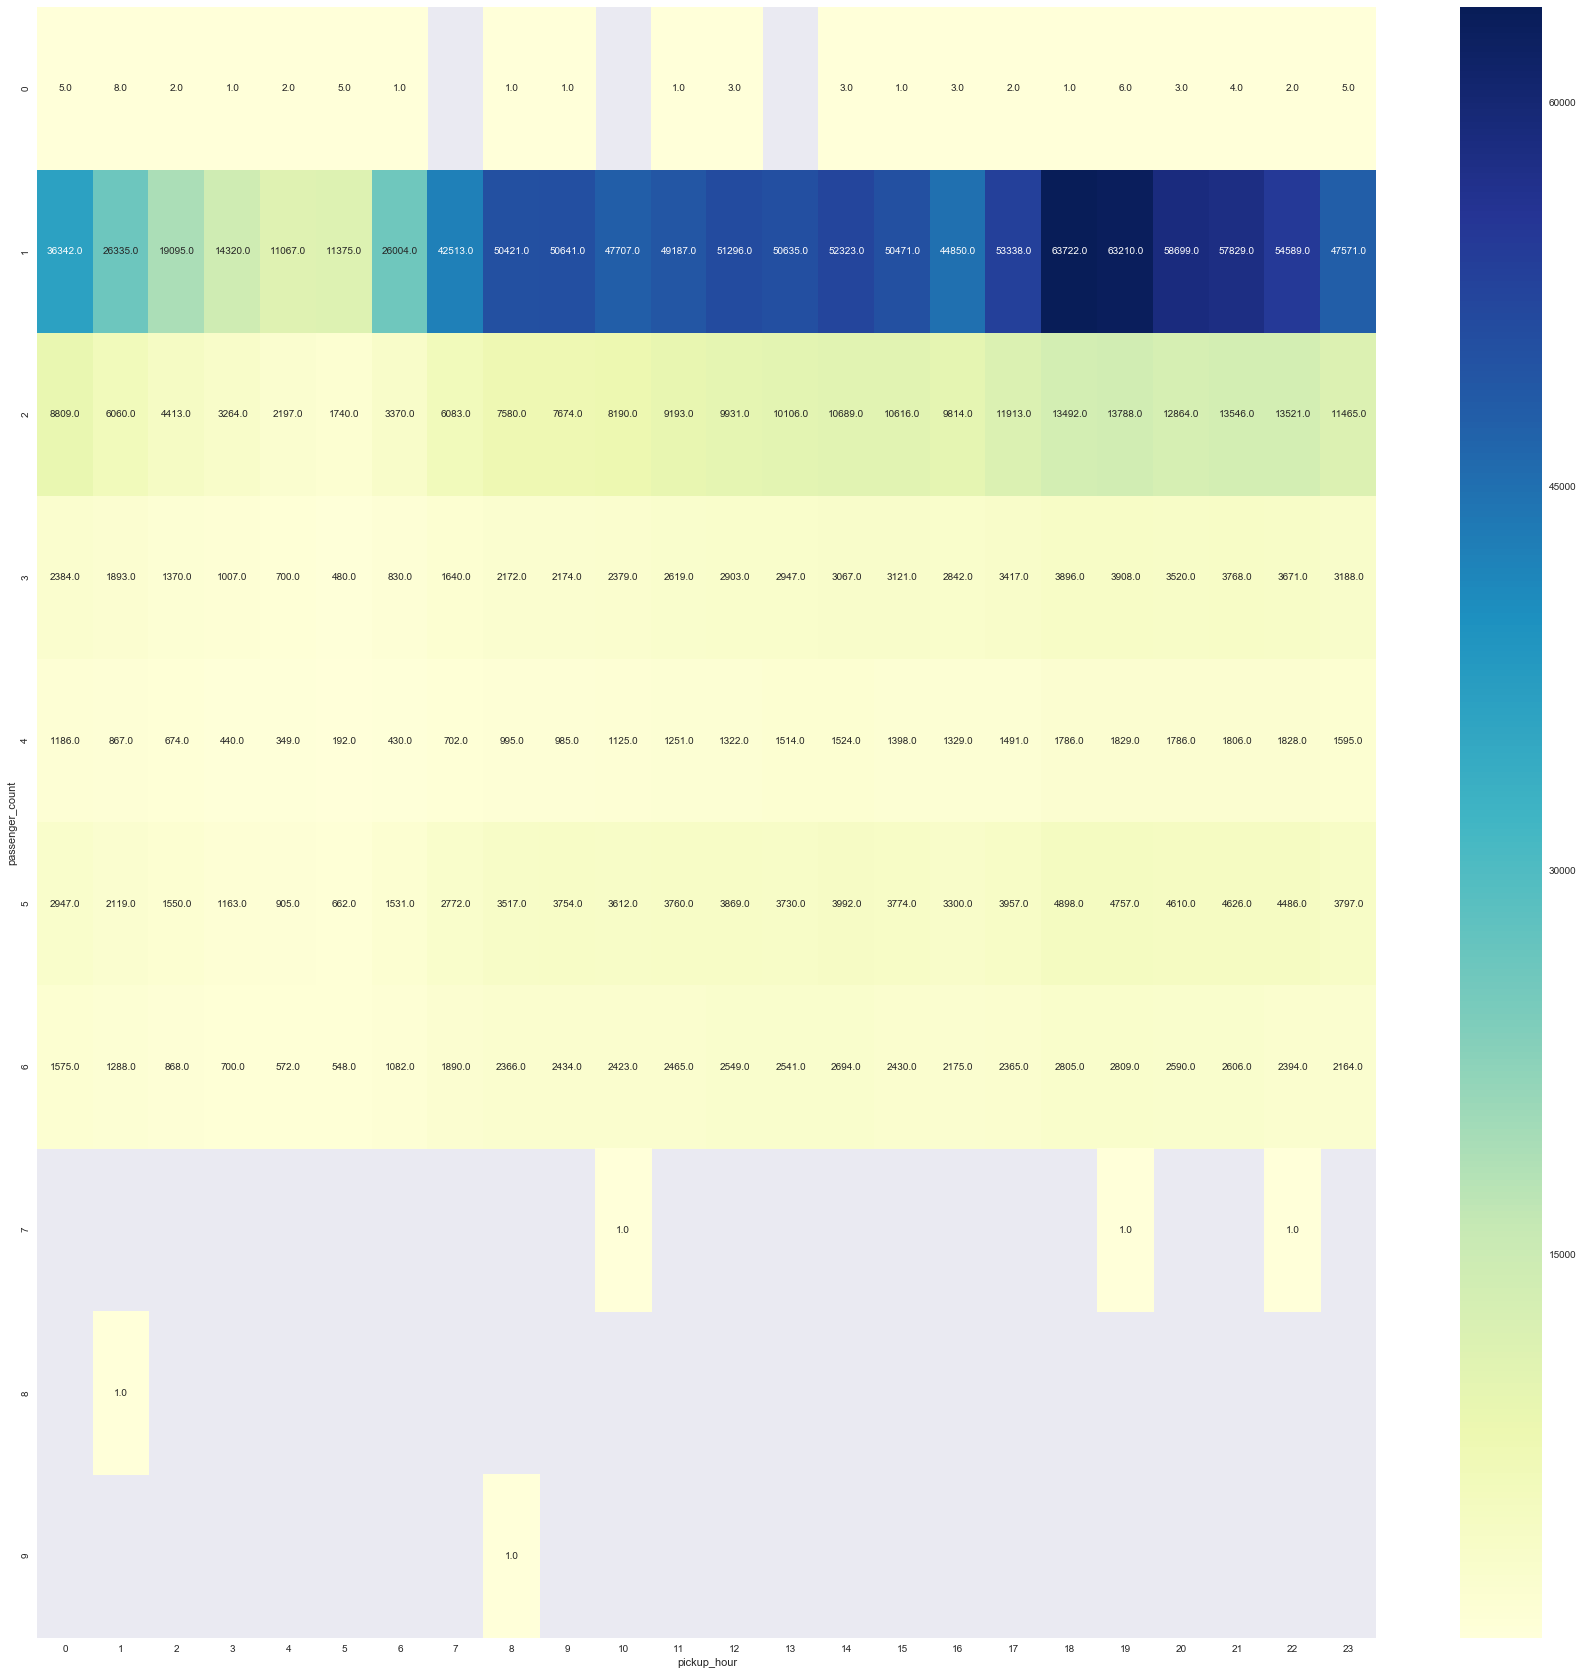

In [19]:
plt.figure(figsize = (30,30))
sns.heatmap(passenger_pivot1, cmap="YlGnBu", annot=True, fmt="")

In [ ]:
#### 승객수와 승차시점 관계 (pickup_weekday)

In [22]:
passenger_pivot2 = taxi_df2.pivot_table(values="count", index=["passenger_count"], columns=["pickup_weekday"], aggfunc=np.sum)
passenger_pivot2.fillna(value=0)

pickup_weekday,0,1,2,3,4,5,6
passenger_count,,,,,,,
0,10.0,3.0,4.0,8.0,10.0,12.0,13.0
1,135346.0,147704.0,153040.0,158543.0,158773.0,147889.0,132245.0
2,25858.0,26601.0,27711.0,29380.0,31930.0,37094.0,31744.0
3,7278.0,7429.0,7779.0,8061.0,9085.0,10778.0,9486.0
4,3362.0,3355.0,3521.0,3619.0,4437.0,5490.0,4620.0
5,9543.0,10899.0,11212.0,11692.0,11881.0,12068.0,10793.0
6,6021.0,6757.0,6869.0,7271.0,7415.0,7536.0,6464.0
7,0.0,1.0,0.0,0.0,0.0,1.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0


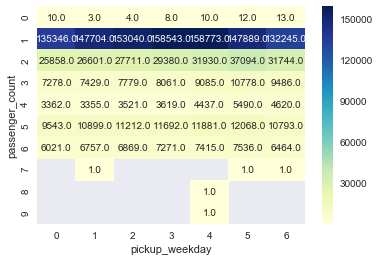

In [23]:
sns.heatmap(passenger_pivot2, cmap="YlGnBu", annot=True, fmt="")

In [ ]:
### 승객수와 운행시간 관계 (trip_duration) - 승객수가 많을 수록 duration이 길어질 것이다. (장기)

In [21]:
passenger_num_1 = taxi_df1.loc[:, ["passenger_count", "trip_duration"]]
passenger_num_1.groupby("passenger_count").mean()

,trip_duration
passenger_count,
0,1718.433333
1,930.399753
2,1005.458335
3,1028.236276
4,1053.529749
5,1070.232174
6,1061.355223
7,19.666667
8,104.000000


In [ ]:
### EDA 결과
- 승객수 Max 9인, Min 0인 : 0인, 7인이상 삭제 검토 (총 65건)
- 승객수 지표 : 1인 승차객이 전체 약 146만 건 중 103만 건의 비중, 2인 승차객 21만건 / 5인 / 3인 순
- 승객수&승차시각 : 오전 8시 이후 1인 승차객 중심으로 전 시간대 고른 분포
- 승객수&승차요일 : 전반적으로 고른 분포 , 전반적으로 주말보다 수~금 승차건수가 높음
- 승객수&운행시간 : 1인 승객이 평균 1~2분정도 짧게 운행. 전반적으로 1000~1100초 (16분대), 탑승객 없는 택시 유일하게 30분 수준 (공항으로 이동?)